In [35]:
  import pandas as pd
  from scipy.stats import beta, norm, lognorm
  import numpy as np

  # Paso 1: Cargar el CSV desde GitHub
  url = "https://raw.githubusercontent.com/ladyguillen01/ControlT/refs/heads/main/saldo.csv"
  df = pd.read_csv(url)

  # Verificar columnas
  print("Columnas en el CSV:")
  print(df.columns.tolist())
  print("Primeras filas:")
  print(df.head())

  # Paso 2: Análisis de porcdeuda
  porcdeuda_values = df['porcdeuda']
  pdcalibrado_values = df['pdcalibrado']
  print(f"Número de filas: {len(df)}")
  print(f"Media de porcdeuda: {porcdeuda_values.mean():.6f}")
  print(f"Varianza de porcdeuda: {porcdeuda_values.var():.6f}")
  print(f"Media de pdcalibrado: {pdcalibrado_values.mean():.6f}")
  print(f"Valores extremos de porcdeuda: min={porcdeuda_values.min():.6f}, max={porcdeuda_values.max():.6f}")

Columnas en el CSV:
['CODMES_COSECHA', 'CODMES_PORTAFOLIO', 'CTDMESMADURACION', 'mtodeuda_inicial', 'mtodeuda', 'porcdeuda', 'pdcalibrado']
Primeras filas:
   CODMES_COSECHA  CODMES_PORTAFOLIO  CTDMESMADURACION  mtodeuda_inicial  \
0          202402             202407                 5      5.592976e+08   
1          202402             202406                 4      5.592976e+08   
2          202402             202506                16      5.592976e+08   
3          202402             202403                 1      5.592976e+08   
4          202402             202411                 9      5.592976e+08   

       mtodeuda  porcdeuda  pdcalibrado  
0  3.312146e+08   0.592197     0.036526  
1  3.614423e+08   0.646243     0.036526  
2  1.376123e+08   0.246045     0.036526  
3  4.841421e+08   0.865625     0.036526  
4  2.369566e+08   0.423668     0.036526  
Número de filas: 253
Media de porcdeuda: 0.563884
Varianza de porcdeuda: 0.050581
Media de pdcalibrado: 0.027616
Valores extremos de po

In [42]:
!pip install lifelines --no-cache-dir

In [43]:
from lifelines import WeibullAFTFitter


📌 Parámetros Weibull:
shape (k)=2.723148379408018, scale=0.6155970881163554

📌 Parámetros Exponencial:
lambda=1.8309508892659214


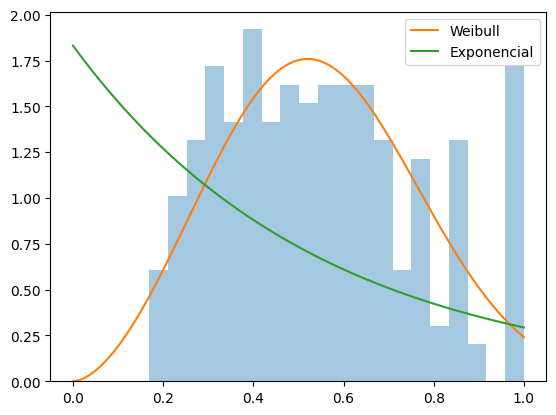

In [45]:
import pandas as pd
import numpy as np
from scipy.stats import weibull_min, expon
import matplotlib.pyplot as plt

url = "https://raw.githubusercontent.com/ladyguillen01/ControlT/refs/heads/main/saldo.csv"
df = pd.read_csv(url)

df = df[(df["CODMES_COSECHA"] > 202400) & (df["CODMES_COSECHA"] < 202506)]
if df["porcdeuda"].max() > 1:
    df["porcdeuda"] = df["porcdeuda"]/100

y = df["porcdeuda"].values

# Fit Weibull
shape, loc, scale = weibull_min.fit(y, floc=0)
print("📌 Parámetros Weibull:")
print(f"shape (k)={shape}, scale={scale}")

# Fit Exponencial
loc_e, scale_e = expon.fit(y, floc=0)
print("\n📌 Parámetros Exponencial:")
print(f"lambda={1/scale_e}")

# Plot para visualizar ajuste
x = np.linspace(0,1,200)
plt.hist(y, bins=20, density=True, alpha=0.4)
plt.plot(x, weibull_min.pdf(x, shape, loc=0, scale=scale), label="Weibull")
plt.plot(x, expon.pdf(x, loc=0, scale=scale_e), label="Exponencial")
plt.legend()
plt.show()

✔ Weibull ajustada al tiempo:
shape = 0.7784110632829511
scale = 11.144899683142215


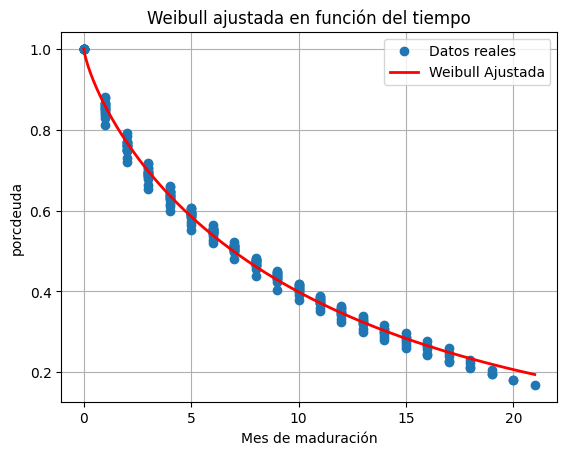

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# FUNCIÓN DECAIMIENTO WEIBULL
def weibull_decay(t, shape, scale):
    return np.exp(- (t/scale)**shape)

df = df.sort_values("CTDMESMADURACION")
t = df["CTDMESMADURACION"].values
y = df["porcdeuda"].values

# AJUSTE CURVA A Y~t
popt, pcov = curve_fit(weibull_decay, t, y, bounds=(0, np.inf))
shape, scale = popt

print(f"✔ Weibull ajustada al tiempo:")
print(f"shape = {shape}")
print(f"scale = {scale}")

# PREDICCIÓN
t_pred = np.linspace(t.min(), t.max(), 400)
y_pred = weibull_decay(t_pred, shape, scale)

# GRAFICO FINAL
plt.plot(t, y, 'o', label="Datos reales")
plt.plot(t_pred, y_pred, 'r-', label="Weibull Ajustada", linewidth=2)
plt.xlabel("Mes de maduración")
plt.ylabel("porcdeuda")
plt.title("Weibull ajustada en función del tiempo")
plt.legend()
plt.grid()
plt.show()



📌 Resultados del modelo Weibull con X1 y X2
shape  = 0.7784111053988158
β0     = 2.4109819708884093
β1_pd  = 2.553166734719561e-24
β2_mad = 1.1885252148571094e-21


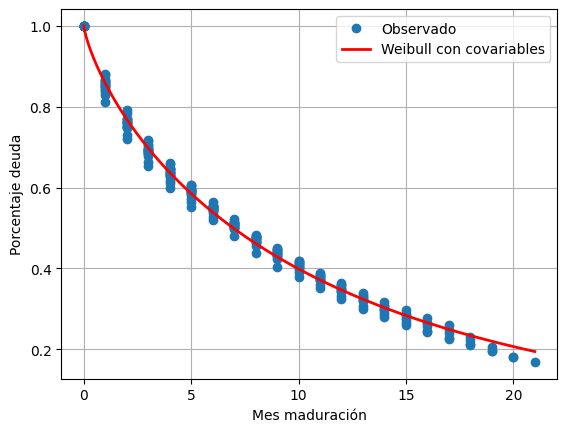

In [48]:
import numpy as np
from scipy.optimize import curve_fit

# 🔥 Modelo Weibull con covariables
def weibull_cov(t, pd, mad, shape, b0, b1, b2):
    scale = np.exp(b0 + b1*pd + b2*mad)
    return np.exp(- (t/scale)**shape)

t   = df["CTDMESMADURACION"].values
pd  = df["pdcalibrado"].values
mad = df["CTDMESMADURACION"].values  # se puede usar junto a pdcalibrado

y   = df["porcdeuda"].values

# Ajuste
popt, pcov = curve_fit(lambda data_t, shape, b0, b1, b2:
                       weibull_cov(data_t, pd, mad, shape, b0, b1, b2),
                       t, y, bounds=(0, np.inf))

shape, b0, b1, b2 = popt
print("\n📌 Resultados del modelo Weibull con X1 y X2")
print(f"shape  = {shape}")
print(f"β0     = {b0}")
print(f"β1_pd  = {b1}")
print(f"β2_mad = {b2}")

# Predicción para graficar
t_pred = np.linspace(min(t), max(t), 500)
y_pred = weibull_cov(t_pred, pd.mean(), mad.mean(), shape, b0, b1, b2)

import matplotlib.pyplot as plt
plt.plot(t, y,'o', label="Observado")
plt.plot(t_pred, y_pred,'r-', lw=2, label="Weibull con covariables")
plt.xlabel("Mes maduración")
plt.ylabel("Porcentaje deuda")
plt.legend()
plt.grid()
plt.show()


In [49]:
import pandas as pd
import numpy as np
import plotly.graph_objs as go
import plotly.express as px

# --- 1) carga y filtro de datos ---
url = "https://raw.githubusercontent.com/ladyguillen01/ControlT/refs/heads/main/saldo.csv"
df = pd.read_csv(url)
df = df[(df["CODMES_COSECHA"] > 202400) & (df["CODMES_COSECHA"] < 202506)]

# suponiendo ya transformaste porcdeuda a proporción 0-1
if df["porcdeuda"].max() > 1:
    df["porcdeuda"] = df["porcdeuda"] / 100

# parámetros estimados del modelo
shape = 0.7784111053988158
b0 = 2.4109819708884093
b1 = 2.553166734719561e-24
b2 = 1.1885252148571094e-21

def porcdeuda_model(t, pd, mad):
    scale = np.exp(b0 + b1*pd + b2*mad)
    return np.exp(- (t / scale)**shape)

# --- 2) crear figura con traces por cada CODMES_COSECHA ---
fig = go.Figure()

for cosecha, dfi in df.groupby("CODMES_COSECHA"):
    # datos reales
    fig.add_trace(go.Scatter(
        x = dfi["CTDMESMADURACION"],
        y = dfi["porcdeuda"],
        mode = "markers+lines",
        name = f"Real {cosecha}",
        visible = False  # los mostramos solo cuando se seleccione
    ))
    # predicción modelo (curva)
    t_seq = np.linspace(dfi["CTDMESMADURACION"].min(),
                        dfi["CTDMESMADURACION"].max(), 100)
    y_pred = porcdeuda_model(t_seq,
                             pd = dfi["pdcalibrado"].mean(),
                             mad = t_seq  # si mad = t; ajustar si es distinto
                            )
    fig.add_trace(go.Scatter(
        x = t_seq,
        y = y_pred,
        mode = "lines",
        line = dict(dash="dash"),
        name = f"Model {cosecha}",
        visible = False
    ))

# --- 3) crear dropdown para seleccionar por CODMES_COSECHA ---
all_cosechas = sorted(df["CODMES_COSECHA"].unique())
buttons = []
for i, cosecha in enumerate(all_cosechas):
    # cada cosecha tiene 2 traces (real y model) en orden
    idx_real = i*2
    idx_mod  = i*2 + 1
    visible = [False] * (len(all_cosechas)*2)
    visible[idx_real] = True
    visible[idx_mod]  = True
    buttons.append(dict(
        label = str(cosecha),
        method = "update",
        args = [{"visible": visible},
                {"title": f"CODMES_COSECHA = {cosecha}"}]
    ))

fig.update_layout(
    updatemenus=[dict(
        active=0,
        buttons=buttons,
        x=1.15,
        y=0.5
    )],
    xaxis_title="Mes de Maduración (CTDMESMADURACION)",
    yaxis_title="porcdeuda",
    title=f"Deuda real vs modelo Weibull por CODMES_COSECHA ({all_cosechas[0]})"
)

# activar la primera cosecha por defecto
fig.data[0].visible = True
fig.data[1].visible = True

fig.show()


In [50]:
import pandas as pd
import numpy as np
import plotly.graph_objs as go

# === Cargar y filtrar dataset ===
url = "https://raw.githubusercontent.com/ladyguillen01/ControlT/refs/heads/main/saldo.csv"
df = pd.read_csv(url)

df = df[(df["CODMES_COSECHA"] > 202400) & (df["CODMES_COSECHA"] < 202506)]

# Normalización si viene en 0-100
if df["porcdeuda"].max() > 1:
    df["porcdeuda"] = df["porcdeuda"] / 100

# === Parámetros Weibull estimados ===
shape = 0.7784111053988158
b0 = 2.4109819708884093
b1 = 2.553166734719561e-24
b2 = 1.1885252148571094e-21

# Modelo Weibull dependiente de pdcalibrado + maduración
def porcdeuda_model(t, pd, mad):
    scale = np.exp(b0 + b1*pd + b2*mad)
    return np.exp(- (t / scale)**shape)

# === GRAFICAR TODAS LAS COSECHAS EN CAPAS ===
fig = go.Figure()

for cosecha, dfi in df.groupby("CODMES_COSECHA"):

    # curvas proyectadas
    t_seq = np.linspace(dfi["CTDMESMADURACION"].min(),
                        dfi["CTDMESMADURACION"].max(), 120)
    y_pred = porcdeuda_model(t_seq,
                             pd = dfi["pdcalibrado"].mean(),
                             mad = t_seq)

    # línea de pronóstico
    fig.add_trace(go.Scatter(
        x=t_seq, y=y_pred, mode="lines",
        name=f"Modelo {cosecha}",
        opacity=0.55 # para ver superposición
    ))

    # puntos reales
    fig.add_trace(go.Scatter(
        x=dfi["CTDMESMADURACION"], y=dfi["porcdeuda"],
        mode="markers",
        name=f"Real {cosecha}",
        marker=dict(size=5),
        opacity=0.8
    ))

fig.update_layout(
    title="Todas las curvas de decrecimiento de deuda por CODMES_COSECHA (Real vs Modelo)",
    xaxis_title="Mes de Maduración",
    yaxis_title="Porcentaje de Deuda",
    legend_title="Series",
    height=650
)

fig.show()
